In [2]:
import h5py
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import gwsurrogate

from scipy import signal
from scipy.special import sph_harm
from scipy.interpolate import CubicSpline
from pycbc.detector import Detector
from gwpy.timeseries import TimeSeries
from gwpy.detector import Channel
import scri

from math import pi
import gwsurrogate

from matplotlib import rc
from spherical_functions import LM_index as lm

#rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


In [3]:
sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_sur

Loaded NRSur7dq4 model


## Functions for reading in waveforms, and ramp function for tapering, and functions for evaluating surrogate

In [54]:
def ReadExtrapolatedModesPlain(file, mode, order = 2, mass = 68 * const.M_sun, distance = 400000 * const.kpc, dt=1/2048):

    f = h5py.File(file, 'r')
    
    l = mode[0]
    m = mode[1]
    data = f['Extrapolated_N'+str(order)+'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    t = data[:,0]
    re = data[:,1]
    im = data[:,2]
    #re = re * const.G*mass/((const.c)**2*distance)
    #im = im * const.G*mass/((const.c)**2*distance)  
    #t = t*mass*const.G/(const.c**3)
    ## Subtract peak time
    
    amp = np.sqrt(re**2 + im**2)
    t_peak = t[np.argmax(amp)]
    t = t - t_peak
    
    return t, re, im
    
def EvaluateSurrogatePlain(mode, q, chiA, chiB, mass = 68 * const.M_sun, distance = 400000 * const.kpc):

    l = mode[0]
    m = mode[1]
    
    modes = sur(q, chiA, chiB, dt = 1 / 2048, f_low = 0.02, ellMax = 2)
    sur_t = modes[0]
    print(modes[1])
    h = modes[1][(l, m)]
    
    sur_re = np.real(h)
    sur_im = -1.0 * np.imag(h)
    
    #modes = sur(q, chiA, chiB, init_phase=phase)
    #sur_re = modes[l, m].real
    #sur_im = modes[l, m].imag
    #sur_t = sur.t_coorb
    
    ## Subtract peak time
    sur_amp = np.sqrt(sur_re**2 + sur_im**2)
    sur_t_peak = sur_t[np.argmax(sur_amp)]
    sur_t = sur_t - sur_t_peak
    
    return sur_t, sur_re, sur_im

    

In [55]:
q = 1.22125321379
chiA = np.array([0, 0, 0.33]) 
chiB = np.array([0, 0, -0.44])
mode = (2,2)
EvaluateSurrogatePlain(mode, q, chiA, chiB)

{(2, -2): array([2.31745969e-01-8.65568806e-04j,
       2.31746349e-01-8.51373262e-04j,
       2.31746729e-01-8.37177644e-04j, ...,
       1.82835699e-04+4.95557311e-05j,
       1.82818505e-04+4.96029627e-05j,
       1.82801311e-04+4.96501943e-05j]), (2, -1): array([-3.34411693e-04+2.39408371e-03j,
       -3.34490277e-04+2.39407478e-03j,
       -3.34568860e-04+2.39406584e-03j, ...,
        9.66698452e-06-5.88310585e-06j,
        9.66843403e-06-5.88143744e-06j,
        9.66988351e-06-5.87976906e-06j]), (2, 0): array([ 2.26038496e-07-4.56783794e-07j,
        2.39409549e-07-4.56868366e-07j,
        2.52780197e-07-4.56952946e-07j, ...,
       -4.90279998e-05+3.15098969e-08j,
       -4.90256721e-05+3.13746910e-08j,
       -4.90233443e-05+3.12394823e-08j]), (2, 1): array([-3.28175724e-04-2.39384385e-03j,
       -3.28253661e-04-2.39383726e-03j,
       -3.28331598e-04-2.39383066e-03j, ...,
       -1.01774960e-05+7.88306147e-06j,
       -1.01779926e-05+7.88485811e-06j,
       -1.01784891e-05+7.

(array([-86.96289062, -86.96240234, -86.96191406, ...,
        100.33544922, 100.3359375 , 100.33642578]),
 array([2.31746955e-01, 2.31747334e-01, 2.31747713e-01, ...,
        1.83117207e-04, 1.83100594e-04, 1.83083981e-04]),
 array([-8.53261928e-04, -8.39066793e-04, -8.24871586e-04, ...,
         4.74111530e-05,  4.74584369e-05,  4.75057207e-05]))

## Plot surrogate results over waveform

0.0
{(2, -2): array([2.31745969e-01-8.65568806e-04j,
       2.31746349e-01-8.51373262e-04j,
       2.31746729e-01-8.37177644e-04j, ...,
       1.82835699e-04+4.95557311e-05j,
       1.82818505e-04+4.96029627e-05j,
       1.82801311e-04+4.96501943e-05j]), (2, -1): array([-3.34411693e-04+2.39408371e-03j,
       -3.34490277e-04+2.39407478e-03j,
       -3.34568860e-04+2.39406584e-03j, ...,
        9.66698452e-06-5.88310585e-06j,
        9.66843403e-06-5.88143744e-06j,
        9.66988351e-06-5.87976906e-06j]), (2, 0): array([ 2.26038496e-07-4.56783794e-07j,
        2.39409549e-07-4.56868366e-07j,
        2.52780197e-07-4.56952946e-07j, ...,
       -4.90279998e-05+3.15098969e-08j,
       -4.90256721e-05+3.13746910e-08j,
       -4.90233443e-05+3.12394823e-08j]), (2, 1): array([-3.28175724e-04-2.39384385e-03j,
       -3.28253661e-04-2.39383726e-03j,
       -3.28331598e-04-2.39383066e-03j, ...,
       -1.01774960e-05+7.88306147e-06j,
       -1.01779926e-05+7.88485811e-06j,
       -1.01784891e-0

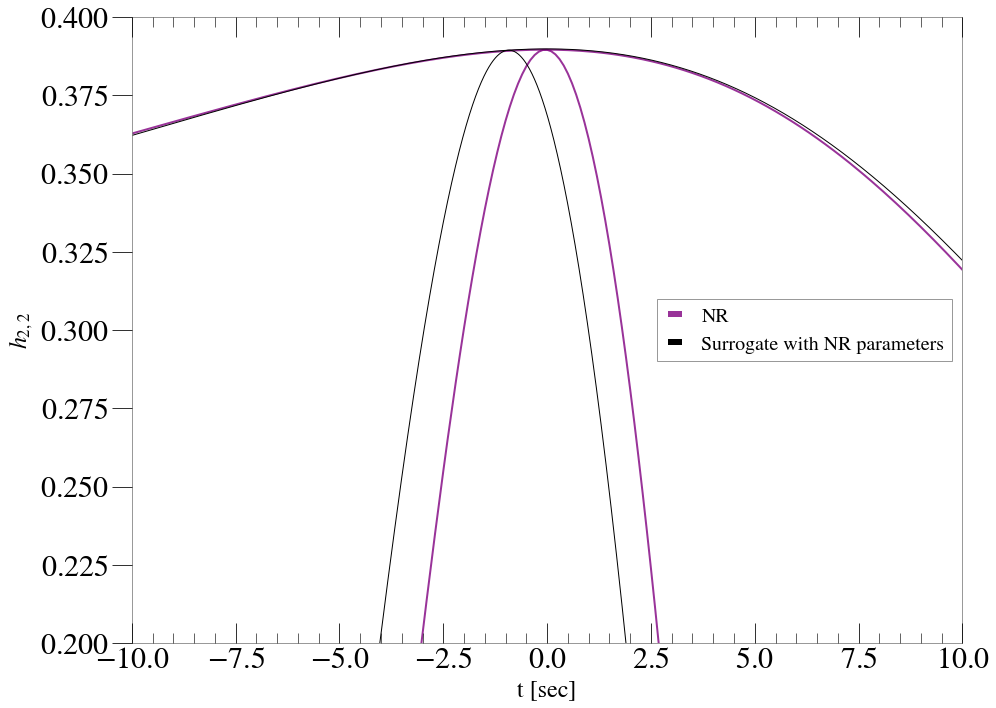

In [57]:
## Mode
mode = [2, 2]

## True physical parameters
q = 1.22125321379
chiA = np.array([0, 0, 0.33]) 
chiB = np.array([0, 0, -0.44])
#mass = 68 * const.M_sun
#distance = 400 * 100 * const.kpc

phase = 0.71

plt.figure(figsize=(14,10))

## Evalute and plot NR waveform
file = "/home/maria.okounkova/BeyondGRAnalysis/Waveforms/dCS_0p0_Lev2/rhOverM_Asymptotic_GeometricUnits_CoM.h5"
t, h_re, h_im = ReadExtrapolatedModesPlain(file, mode, order = 2, dt=1/2048)

t_peak = t[np.argmax(h_re**2 + h_im**2)]
print(t_peak)

plt.plot(t, np.sqrt(h_re**2 + h_im**2), label='NR', lw = 2.0, color='purple', alpha=0.8)
plt.plot(t, h_re, lw = 2.0, color='purple', alpha=0.8)

## Evaluate the surrogate
sur_t, sur_re, sur_im = EvaluateSurrogatePlain(mode, q, chiA, chiB)
t_peak = sur_t[np.argmax(sur_re**2 + sur_im**2)]
print(t_peak)

plt.plot(sur_t, np.sqrt(sur_re**2 + sur_im**2), label='Surrogate with NR parameters', ls = '-', lw = 1.0, color='black')
plt.plot(sur_t, -1.0 * sur_re, lw = 1.0, color='black')

plt.legend(ncol=1, fontsize=20)
plt.ylabel(r'$h_{2,2}$')
plt.xlabel('t [sec]')
plt.xlim(-10, 10)
plt.ylim(0.2, 0.4)
#plt.ylim(2.2e-20, 3.2e-20)
plt.grid()
plt.tight_layout()
plt.savefig('SurrogateComparison.pdf')
plt.show()
